In [1]:
!poetry run python -m pip install torchsde


[notice] A new release of pip available: 22.1.2 -> 22.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!poetry run python -m pip -V

pip 22.1.2 from /home/gflan/.cache/pypoetry/virtualenvs/ancufi--w791oWn-py3.8/lib/python3.8/site-packages/pip (python 3.8)


In [4]:
import torch
from torch import nn
import torchsde
import numpy as np

import os
import sys
import tqdm

In [5]:
is_cuda = torch.cuda.is_available()
# is_cuda = False
device = 'cuda' if is_cuda else 'cpu'
if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

Nuestro modelo, drift y difussion son redes neuronales que vamos a entrenar.

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
        super().__init__()        
        
        activation = lambda : torch.nn.Tanh() if tanh else torch.nn.LeakyReLU(0.01) 
        model = [
            torch.nn.Linear(in_size, mlp_size),
            activation()
        ]
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
            model.append(activation())
        model.append(torch.nn.Linear(mlp_size, out_size))

        self._model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

In [9]:
class SDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'

    def __init__(self, state_size=1, batch_size=32, mlp_size=100, num_layers=3, tanh=False):
        super().__init__()
        
        in_size = 2 * state_size # S(t) y t
        out_size = state_size # drift o difusion final
        mu_sigma_args = dict(
            in_size=in_size,
            out_size=out_size,
            mlp_size=mlp_size, 
            num_layers=num_layers,
            tanh=tanh
        )
        self.mu = MLP(**mu_sigma_args)
        self.sigma = MLP(**mu_sigma_args)

    # Drift
    def f(self, t, y):
        # forward prop de la f
        # armar un tensor de batch_size componentes con el tiempo t
        batch_t = torch.full((batch_size,1), t.item())
        # mu([
        #     (y_0, t), 
        #     (y_1, t),
        #     .. 
        #     (y_n, t) <--- n = batch_size
        # ]) 
        return self.mu(torch.cat((y, batch_t), dim=1))  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        # idem mu
        batch_t = torch.full((batch_size,1), t.item())
        return self.sigma(torch.cat((y, batch_t), dim=1))

# sde = SDE().to(device)

Browniano Geométrico como benchmark conocido

In [10]:
class BGM_SDE(nn.Module):

    def __init__(self, mu, sigma):
        super().__init__()
        self.noise_type="diagonal"
        self.sde_type = "ito"

        self.mu = mu
        self.sigma = sigma

    def f(self, t, y):
        return self.mu * y

    def g(self, t, y):
        return self.sigma * y

## Earth Mover's Distance

In [128]:
def emd(p, q, steps=11):
    quantiles = torch.linspace(0, 1, steps=steps) 
    # tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000, 1.0000])
    quantiles = torch.linspace(0, 1, steps=steps) 
    p_q = torch.quantile(p, quantiles, dim=1, keepdim=True)
    q_q = torch.quantile(q, quantiles, dim=1, keepdim=True)

    # sumo todas las diferencias quartil a quartil 
    return torch.abs(p_q - q_q).sum(dim=0).div(steps)

In [139]:
# Dos normales con misma varianza y un shift de una unidad de media, emd ~= 1 

p = torch.normal(mean=1, std=1, size=(5,300,1), requires_grad=True)
q = torch.normal(mean=0, std=1, size=(5,300,1), requires_grad=True)
print(p.shape) # (cantidad de instantes, tamaño del batch, cantidad de 'estados')

res = emd(p, q, steps=51)
print(res[:, 0, 0], res.mean())
del res, p, q

torch.Size([5, 300, 1])
tensor([0.9703, 1.1266, 0.9261, 1.1032, 1.0250], grad_fn=<SelectBackward0>) tensor(1.0302, grad_fn=<MeanBackward0>)


### TorchSDE

In [191]:
# y0 dimension (batch_size, state_size) da el valor inicial de la SDE en tiempo ts[0]
brownian_size, batch_size, state_size,  = 3, 200, 1
y0 = torch.full((batch_size, state_size), 3)
ts = torch.linspace(0, 1, brownian_size)

sde = SDE(state_size=state_size, batch_size=batch_size, mlp_size=100, num_layers=3, tanh=False).to(device)
bgm = BGM_SDE(mu=.25, sigma=.01)

bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)

with torch.no_grad():
    # Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
    # ys will have shape (t_size, batch_size, state_size)
    ys = torchsde.sdeint(sde, y0, ts, method="euler", bm=bm)        
    ys_bgm = torchsde.sdeint(bgm, y0, ts, method="euler", bm=bm)    
ys[:, :10, :]

tensor([[[3.0000],
         [3.0000],
         [3.0000],
         [3.0000],
         [3.0000],
         [3.0000],
         [3.0000],
         [3.0000],
         [3.0000],
         [3.0000]],

        [[2.9958],
         [2.9826],
         [2.9772],
         [3.0000],
         [3.0124],
         [2.9920],
         [2.9940],
         [3.0122],
         [2.9903],
         [2.9795]],

        [[2.9878],
         [2.9731],
         [2.9687],
         [2.9923],
         [3.0050],
         [2.9877],
         [2.9817],
         [3.0024],
         [2.9807],
         [2.9685]]])

In [199]:
print(ys.shape) # (brownian_size, batch_size, state_size)

distance = emd(ys_bgm, ys, steps=51)
distance

torch.Size([3, 200, 1])


tensor([[[0.0000]],

        [[0.4077]],

        [[0.8696]]])

<AxesSubplot:ylabel='Frequency'>

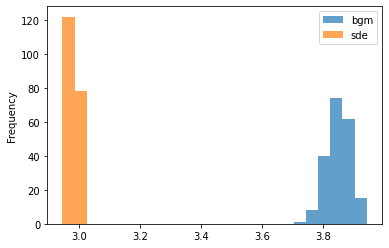

In [198]:
import pandas as pd
pd.DataFrame(
    {
        "bgm": ys_bgm[-1,:,0].numpy(),
        "sde": ys[-1,:,0].numpy()
    }
).plot.hist(alpha=0.7, bins=25)

In [184]:
torchsde.sdeint?

In [243]:
# cargar estados anteriores para iterar por partes
try:
    sde.load_state_dict(torch.load("./state"))
    best_st = pd.read_csv("best_st.csv", index_col=[0]).iloc[:,0].values.tolist()
    best_rt = pd.read_csv("best_rt.csv", index_col=[0]).iloc[:,0].values.tolist()
    losses = pd.read_csv("losses.csv", index_col=[0]).iloc[:,0].values.tolist()
    best_loss = min(losses)
except: 
    print("Starting from zero!")
    losses = []
    best_st = best_rt =  None 
    best_loss = np.inf

Starting from zero!


In [ ]:
steps = 300
steps = 5
ts = torch.linspace(0, 1, 11)
batch_size = 200

a, b = .25, .01 # µ y σ del BGM
sde = SDE(state_size=state_size, batch_size=batch_size, mlp_size=100, num_layers=2, tanh=False).to(device)
gbm = BGM_SDE(mu=a, sigma=b).to(device)
opt = torch.optim.Adam(sde.parameters(), lr=0.1)

y0 = torch.full((batch_size, state_size), 3)
trange = tqdm.tqdm(range(steps))
for step in trange:
    # Nuevo batch, grad en 0
    opt.zero_grad()
    
    # generar traza del GBM
    bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
    st = torchsde.sdeint(gbm, y0, ts, method='euler', bm=bm)
    
    # generar traza de nuestra SDE
    bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
    rt = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm) # (brownian_size, batch_size, state_size)?

    # agarrar las ultimas para comparar
    wasserstein_loss = emd(st, rt, steps=51).mean()
    
    if best_loss > wasserstein_loss.item():
        best_st = st[-1,:,0].detach().numpy() 
        best_rt = rt[-1,:,0].detach().numpy()
        best_loss = wasserstein_loss.item()
    
    losses.append(wasserstein_loss.item())
    # Computar grad
    wasserstein_loss.backward()
    # Optimizar sobre el batch
    opt.step()


 60%|█████████████████████████████████████████████████████████                                      | 3/5 [00:11<00:07,  3.83s/it]

In [427]:
torch.save(sde.state_dict(), "./state")
pd.Series(best_st).to_csv("best_st.csv")
pd.Series(best_rt).to_csv("best_rt.csv")
pd.Series(losses).to_csv("losses.csv")

<AxesSubplot:>

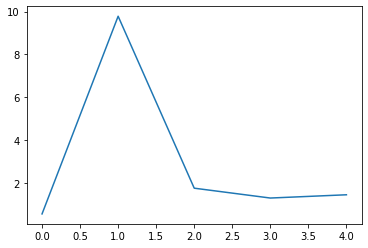

In [241]:
pd.Series(losses).plot()

<AxesSubplot:>

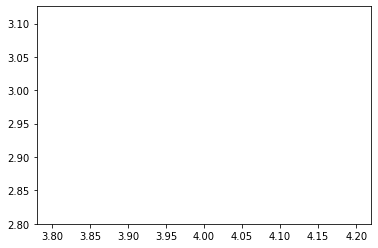

In [239]:
pd.Series(losses).rolling(5).mean().plot()

In [464]:
best_loss

8.304627418518066

<AxesSubplot:ylabel='Frequency'>

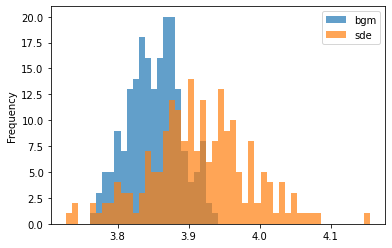

In [218]:
pd.DataFrame(
    {
        "bgm": best_st,
        "sde": best_rt
    }
).plot.hist(alpha=0.7, bins=50)

In [368]:
pd.Series(best_st).describe()

count       200.000000
mean      13455.070312
std       30117.035156
min           3.530167
25%         951.140167
50%        3019.674072
75%       10720.533203
max      222529.781250
dtype: float64

In [257]:
sde.f = lambda x,y: 0*x*y

In [451]:
sts = rts = np.array([])
with torch.no_grad():
    for i in tqdm.tqdm(range(20)):
        y0 = torch.randn(batch_size, state_size, device=device) + 140
        bm_ = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
        st = torchsde.sdeint(gbm, y0, ts, method='euler', bm=bm)
        bm = torchsde.BrownianInterval(t0=0, t1=1, size=(batch_size, state_size), device=device)  
        rt = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm) # (brownian_size, batch_size, state_size)?
        sts = np.append(sts, st[-1:, :, :][0,:,0].detach().numpy())
        rts = np.append(rts, rt[-1:, :, :][0,:,0].detach().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.32s/it]


<AxesSubplot:ylabel='Frequency'>

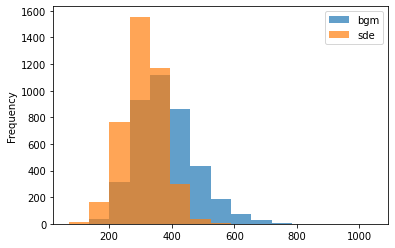

In [452]:
pd.DataFrame(
    {
        "bgm": sts,
        "sde": rts
    }
).plot.hist(alpha=0.7, bins=15)

In [349]:
def price_func(s, k):
  # s y k vectores
  return max(s-k, 0)

In [357]:
best_loss

0.025777267292141914